In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA: True
cuda


In [2]:
import tensorflow as tf

In [3]:
!python --version

Python 3.8.5


In [4]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""
    src_lengths = src_lengths.cpu()

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)
            
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)


In [5]:
def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [6]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break


In [7]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        src_lengths = src_lengths.cpu()
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)


In [8]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


In [9]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  

        return output, final


In [10]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  
        context, attn_probs = self.attention(query=query, proj_key=proj_key,value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output

    def forward(self, trg_embed, encoder_hidden, encoder_final, 
            src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""

        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []

        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]



    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            





        

In [11]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
        
        
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas


In [12]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model


In [13]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                


In [14]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))


In [16]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

    

In [17]:
!export LC_ALL="en_US.UTF-8"

In [18]:
import pandas as pd

In [19]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((de_tensor_, en_tensor_))
  return data


In [20]:
tf.__version__

'2.5.0'

In [21]:
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf

def get_model(model_url, max_seq_length):
    with tf.device('/cpu:0'):
        labse_layer = hub.KerasLayer(model_url, trainable=False)

      # Define input.
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                             name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
        segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="segment_ids")

      # LaBSE layer.
        pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

      # The embedding is l2 normalized.
        pooled_output = tf.keras.layers.Lambda(
        lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

      # Define model.
        labse_model = tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=pooled_output)
    return labse_model, labse_layer
max_seq_length = 10
labse_model, labse_layer = get_model(model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)


In [22]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [23]:
import bert
from bert import tokenization

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
with tf.device('/cpu:0'):
    do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

In [24]:
from torchtext import data

In [25]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return build_vocab_from_iterator(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

ininormer = tokenizer

def tokenize_kz_unnormalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    return out

def tokenize_kz_normalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    return out

In [26]:
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True



In [27]:
SRC = data.Field(tokenize=tokenize_kz_unnormalized, batch_first=True, lower=LOWER, include_lengths=True, unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)

In [28]:
TRG = data.Field(tokenize=tokenize_kz_normalized, batch_first=True, lower=LOWER, include_lengths=True, unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)



In [29]:
MAX_LEN=25

In [30]:
from torchtext.datasets import TranslationDataset


In [31]:
text_dataset = TranslationDataset(path='./', exts=('data_1.ut', 'data_1.nt'), fields=(SRC, TRG))


In [32]:
from torchtext import data, datasets

if True:

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_kz_unnormalized,
                         batch_first=True, lower=LOWER, include_lengths=True,
                         unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
                     
    TRG = data.Field(tokenize=tokenize_kz_normalized,
                         batch_first=True, lower=LOWER, include_lengths=True,
                         unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)                     

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = text_dataset.splits(path='./', exts=('.ut', '.nt'), fields=(SRC, TRG), filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [33]:
vars(train_data[4])['src']

['жамбыл',
 ',',
 'батыс',
 'қазақстан',
 'облыс',
 '##тарының',
 'кей',
 'жерлер',
 '##інде',
 'т',
 '##ұм',
 '##ан',
 'к',
 '##үт',
 '##іледі',
 '.']

In [34]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of Unnormalized words (types):", len(src_field.vocab))
    print("Number of normalizeds (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)


Data set sizes (number of sentence pairs):
train 638
valid 555
test 525 

First training example:
src: — ы ##м - м ! — деп орнынан түр ##еге ##лді .
trg: — ы ##мм ! — деп орнынан түр ##еге ##лді 

Most common words (src):
         .        609
         ,        234
         -        100
         —         70
       ##н         59
         "         49
      ##ға         41
         қ         39
   бойынша         37
       ##ы         36 

Most common words (trg):
         ,        213
       жүз         79
       екі         74
         —         70
       ##н         61
       мың         61
         қ         56
       бір         56
         "         49
         к         41 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 -
06 —
07 ##н
08 "
09 ##ға 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 ,
05 жүз
06 екі
07 —
08 ##н
09 мың 

Number of Unnormalized words (types): 320
Number of normalizeds (types): 330 



In [35]:
type(train_data)

torchtext.datasets.translation.TranslationDataset

In [36]:
train_iter = data.BucketIterator(train_data, batch_size=1, train=True, sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)

In [37]:
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)

In [38]:

def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [39]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [40]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)  
            
            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities
        


In [41]:
!export CUDA_VISIBLE_DEVICES=1


In [42]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)

/home/ghost/anaconda3/envs/py36pyt14/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [43]:
dev_perplexities = train(model, print_every=10)

Epoch 0
Epoch Step: 10 Loss: 30.002338 Tokens per Sec: 64.925918
Epoch Step: 20 Loss: 52.839489 Tokens per Sec: 737.592705
Epoch Step: 30 Loss: 56.454655 Tokens per Sec: 808.928662
Epoch Step: 40 Loss: 24.021862 Tokens per Sec: 814.027533
Epoch Step: 50 Loss: 27.581514 Tokens per Sec: 795.939358
Epoch Step: 60 Loss: 18.111464 Tokens per Sec: 805.768068
Epoch Step: 70 Loss: 65.179932 Tokens per Sec: 695.759662
Epoch Step: 80 Loss: 11.914173 Tokens per Sec: 771.760779
Epoch Step: 90 Loss: 39.820831 Tokens per Sec: 720.809211
Epoch Step: 100 Loss: 49.527702 Tokens per Sec: 694.939791
Epoch Step: 110 Loss: 109.642006 Tokens per Sec: 781.845764
Epoch Step: 120 Loss: 17.025387 Tokens per Sec: 707.842311
Epoch Step: 130 Loss: 38.526962 Tokens per Sec: 664.394020
Epoch Step: 140 Loss: 27.590942 Tokens per Sec: 750.757981
Epoch Step: 150 Loss: 66.042053 Tokens per Sec: 692.540783
Epoch Step: 160 Loss: 47.856693 Tokens per Sec: 708.814987
Epoch Step: 170 Loss: 93.357170 Tokens per Sec: 835.97995

/home/ghost/anaconda3/envs/py36pyt14/lib/python3.6/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths


Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  ,

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ "
Pred:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example #3
Src :  1 , енді бұл екі <unk> <unk> <unk> ##к . . .
Trg :  <unk> , енді бұл екі <unk> <unk> <unk> ##к
Pred:  өзен <unk> , <unk> <unk>

Validation perplexity: 14.173353
Epoch 1
Epoch Step: 10 Loss: 72.082909 Tokens per Sec: 673.714824
Epoch Step: 20 Loss: 31.870096 Tokens per Sec: 725.970868
Epoch Step: 30 Loss: 17.021917 Tokens per Sec: 786.709569
Epoch Step: 40 Loss: 1.603067 Tokens per Sec: 782.013416
Epoch Step: 50 Loss: 59.180050 Tokens per Sec: 726.422677
Epoch Step: 60 Loss: 24.595709 Tokens per Sec: 813.233592
Epoch Step: 70 Loss: 62.910248 Tokens per Sec: 811.097384
Epoch Step: 80 Loss: 78.679398 Tokens per Sec: 794.6

Epoch Step: 590 Loss: 29.487797 Tokens per Sec: 801.532598
Epoch Step: 600 Loss: 37.868858 Tokens per Sec: 806.798623
Epoch Step: 610 Loss: 17.115625 Tokens per Sec: 742.403100
Epoch Step: 620 Loss: 50.686188 Tokens per Sec: 765.512284
Epoch Step: 630 Loss: 41.771175 Tokens per Sec: 718.617571

Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  ,

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ "
Pred:  <unk> <unk> <unk> " , <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##мен <unk> <unk> <unk>

Example #3
Src :  1 , енді бұл екі <unk> <unk> <unk> ##к . . .
Trg :  <unk> , енді бұл екі <unk> <unk> <unk> ##к
Pred:  астана <unk> , <unk> <unk> <unk> <unk>

Validation perplexity: 7.599001
Epoch 3
Epoch Step: 10 Loss: 6.284361 

Epoch Step: 510 Loss: 0.873957 Tokens per Sec: 810.143534
Epoch Step: 520 Loss: 4.855072 Tokens per Sec: 811.400600
Epoch Step: 530 Loss: 10.548916 Tokens per Sec: 806.001141
Epoch Step: 540 Loss: 33.067776 Tokens per Sec: 784.571069
Epoch Step: 550 Loss: 13.327781 Tokens per Sec: 754.408228
Epoch Step: 560 Loss: 5.237005 Tokens per Sec: 758.482279
Epoch Step: 570 Loss: 13.086868 Tokens per Sec: 760.498474
Epoch Step: 580 Loss: 23.406284 Tokens per Sec: 778.563358
Epoch Step: 590 Loss: 4.359571 Tokens per Sec: 851.032592
Epoch Step: 600 Loss: 2.403132 Tokens per Sec: 792.297580
Epoch Step: 610 Loss: 6.469162 Tokens per Sec: 765.102361
Epoch Step: 620 Loss: 34.794270 Tokens per Sec: 845.300999
Epoch Step: 630 Loss: 25.545683 Tokens per Sec: 764.148873

Example #1
Src :  , <unk>
Trg :  , <unk> <unk>
Pred:  , <unk>

Example #2
Src :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> ##ке <unk> қ ##ұ ##қы жоқ . "
Trg :  <unk> , " " " өз <unk> <unk> <unk> <unk> <unk> <u

Epoch Step: 400 Loss: 2.694133 Tokens per Sec: 808.798055
Epoch Step: 410 Loss: 7.129378 Tokens per Sec: 822.391963
Epoch Step: 420 Loss: 8.878822 Tokens per Sec: 862.072358
Epoch Step: 430 Loss: 1.996761 Tokens per Sec: 837.960272
Epoch Step: 440 Loss: 4.999410 Tokens per Sec: 802.585203
Epoch Step: 450 Loss: 1.024964 Tokens per Sec: 787.794815
Epoch Step: 460 Loss: 6.456123 Tokens per Sec: 824.336558
Epoch Step: 470 Loss: 7.022364 Tokens per Sec: 813.097233
Epoch Step: 480 Loss: 5.691071 Tokens per Sec: 835.141125
Epoch Step: 490 Loss: 3.061993 Tokens per Sec: 812.928385
Epoch Step: 500 Loss: 4.843996 Tokens per Sec: 817.523438
Epoch Step: 510 Loss: 7.054939 Tokens per Sec: 864.901845
Epoch Step: 520 Loss: 20.410400 Tokens per Sec: 834.474593
Epoch Step: 530 Loss: 29.121027 Tokens per Sec: 840.068952
Epoch Step: 540 Loss: 10.032423 Tokens per Sec: 801.244366
Epoch Step: 550 Loss: 6.592482 Tokens per Sec: 829.623535
Epoch Step: 560 Loss: 21.573689 Tokens per Sec: 855.283198
Epoch Step

Epoch Step: 340 Loss: 6.385601 Tokens per Sec: 750.616258
Epoch Step: 350 Loss: 1.202150 Tokens per Sec: 791.087294
Epoch Step: 360 Loss: 6.849794 Tokens per Sec: 780.246658
Epoch Step: 370 Loss: 1.720154 Tokens per Sec: 747.086483
Epoch Step: 380 Loss: 32.199570 Tokens per Sec: 724.551665
Epoch Step: 390 Loss: 6.840900 Tokens per Sec: 740.117788
Epoch Step: 400 Loss: 1.317819 Tokens per Sec: 800.966646
Epoch Step: 410 Loss: 0.451894 Tokens per Sec: 747.621370
Epoch Step: 420 Loss: 7.830525 Tokens per Sec: 778.451993
Epoch Step: 430 Loss: 2.014314 Tokens per Sec: 783.733019
Epoch Step: 440 Loss: 17.791538 Tokens per Sec: 775.827777
Epoch Step: 450 Loss: 9.376375 Tokens per Sec: 700.700916
Epoch Step: 460 Loss: 10.326880 Tokens per Sec: 731.748085
Epoch Step: 470 Loss: 0.241662 Tokens per Sec: 738.390470
Epoch Step: 480 Loss: 13.146062 Tokens per Sec: 777.588993
Epoch Step: 490 Loss: 20.627201 Tokens per Sec: 798.170613
Epoch Step: 500 Loss: 15.851270 Tokens per Sec: 819.690408
Epoch St

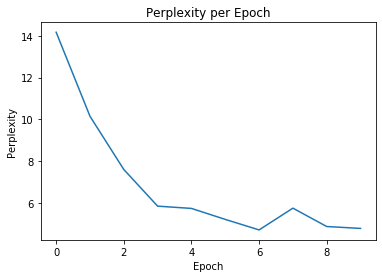

In [44]:

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(dev_perplexities)


In [48]:
import sacrebleu

In [69]:
len(valid_data)

555

In [70]:
references = [" ".join(example.trg) for example in valid_data]

In [71]:
hypotheses = []
alphas = []  
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)


In [72]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]

In [73]:
hypotheses = [" ".join(x) for x in hypotheses]

In [74]:
print(len(hypotheses))
print(hypotheses[2])

555
бір бүт ##ін жүз ##ден екі бұл <unk> <unk>


In [75]:
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score

In [76]:
print(bleu)

8.864976863024914


In [77]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()


In [84]:
hypotheses[13]

'<unk> , <unk> ##с жеті бүт ##ін жүз секс ##ен жеті ж'

src ['20', ',', 'содан', 'бері', 'бірде', 'бір', 'рет', 'күрделі', 'жөндеу', '##ден', 'ө', '##т', '##пеген', '.', '</s>']
ref ['20', ',', 'содан', 'бері', 'бірде', 'бір', 'рет', 'күрделі', 'жөндеу', '##ден', 'ө', '##т', '##пеген', '</s>']
pred ['<unk>', ',', '<unk>', '<unk>', '<unk>', 'бір', '<unk>', '<unk>', 'ө', '<unk>', 'ө', '<unk>', '<unk>', '<unk>', '</s>']


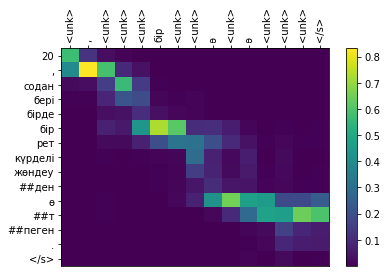

In [86]:
idx = 14
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)